# Neuropixel Spiking and LFP analysis

- [Original Article](https://www.nature.com/articles/s41586-019-1787-x)
- [Neuromatch Notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/projects/neurons/load_steinmetz_decisions.ipynb#scrollTo=J4a1U2AnrDb_)
- [Dataset](https://uni-bonn.sciebo.de/s/Z66tPbIFGGSA3FD)

## Import

In [1]:
import numpy as np
import scipy.signal as sig
import netCDF4 as nc
import matplotlib.pyplot as plt
from pathlib import Path
import os
import scipy.stats as stats
from specparam import SpectralModel, SpectralGroupModel
from specparam.analysis import get_band_peak_group
import seaborn as sns

## Load data

In [2]:
# create path for sourcedata steinmetz using pathlib
source_path = Path(os.getcwd()).parent / "sourcedata"
data_path = os.path.join(source_path, "steinmetz_2016-12-14_Cori.nc")
data = nc.Dataset(data_path)

## Extract LFP

In [3]:
brain_area = "MOs"
brain_area_lfp_idx = np.where(data.variables["brain_area_lfp"][:] == brain_area)[0][0]
area_lfp = data.variables["lfp"][brain_area_lfp_idx].data

In [4]:
sample_rate = 100
freqs, pwr = sig.welch(area_lfp, fs=sample_rate, nperseg=sample_rate // 2)

median_psd = np.median(pwr, axis=1)
mean_psd = np.mean(pwr, axis=1)

pwr.shape


(364, 26)

## Extract spiking

In [5]:
brain_area = "MOs"
brain_area_spike_idx = np.where(data.variables["brain_area"][:] == brain_area)[0]
brain_area_spike_idx
area_spiking = data.variables["spike_rate"][brain_area_spike_idx].data

spiking_activity = np.mean(area_spiking, axis=0)
spiking_activity_hz = 1 / spiking_activity

/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_14088/4008853292.py:7: RuntimeWarning: divide by zero encountered in divide
  spiking_activity_hz = 1 / spiking_activity


In [6]:
area_spiking.shape

(113, 364, 250)

## Find best neuron

In [7]:
rhos = []
pvals = []
for neuron in range(area_spiking.shape[0]):
    single_neuron_spike_rate = area_spiking[neuron].mean(-1)
    rho, pval = stats.spearmanr(mean_psd, single_neuron_spike_rate)
    rhos.append(rho)
    pvals.append(pval)
rhos = np.array(rhos)
pvals = np.array(pvals)

argmax = np.argmax(rhos)

print(f"Max idx={argmax}: rho={rhos[argmax]:.2f}, p={pvals[argmax]:.2f}")

best_neuron = area_spiking[argmax]

Max idx=59: rho=0.56, p=0.00


## Find best trials

In [23]:
rhos = []
pvals = []
for trials30 in range(best_neuron.shape[0] - 30):
    mask = slice(trials30, trials30+30)
    single_neuron_spike_rate = best_neuron[mask].mean(-1)
    rho, pval = stats.spearmanr(mean_psd[mask], single_neuron_spike_rate)
    rhos.append(rho)
    pvals.append(pval)
rhos = np.array(rhos)
pvals = np.array(pvals)

argmax_trial = np.nanargmax(rhos)

print(f"Max idx={argmax_trial}: rho={rhos[argmax_trial]:.2f}, p={pvals[argmax_trial]:.2f}")

Max idx=226: rho=0.83, p=0.00


/Users/moritzgerster/anaconda3/envs/hackathon/lib/python3.12/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [8]:
best_neuron.shape

(364, 250)

(array([238.,   0.,   0.,   0.,   0.,  11.,   0.,   0.,   0.,   1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

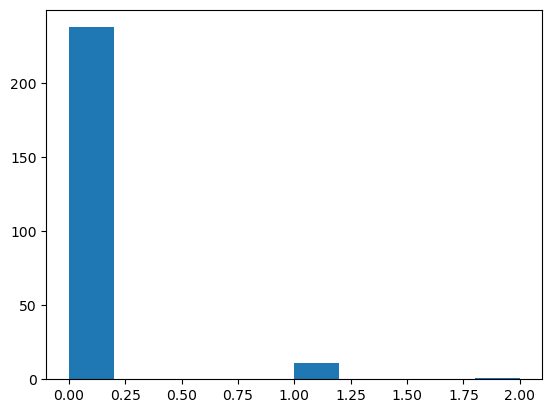

In [9]:
plt.hist(best_neuron[-1])

In [10]:
assert area_lfp.shape == spiking_activity.shape, "Shapes don't match"

In [11]:
# # convert 250 ms windows of area_lfp into 500 ms windows by concatenating every two windows
# area_lfp_500 = np.concatenate([area_lfp[i:i+2] for i in range(0, area_lfp.shape[0], 2)])
# assert area_lfp_500.shape == 364//2, 500

## Fit FOOOF

In [12]:
fooof_params = {"max_n_peaks": 1, "peak_width_limits": (4, 8), "verbose": True}
fit_range = [1, 50]

## Correlate Mean aperiodic PSD and Spiking

In [13]:
# fm = SpectralModel(**fooof_params)
# fm.fit(freqs, pwr[0], freq_range=fit_range)
# fm.report(plt_log=False)

In [14]:
# exp = fm.get_params('aperiodic_params', 'exponent')
# offset = fm.get_params('aperiodic_params', 'offset')
# aperiodic_power = 10**offset * freqs[1:]**(-exp)
# mean_ap = aperiodic_power.mean()
# mean_ap = np.ones(freqs[1:].shape) * mean_ap
# plt.loglog(freqs[1:], aperiodic_power, label="Model Fit")
# plt.loglog(freqs[1:], pwr[0][1:], label="Power Spectrum")
# plt.loglog(freqs[1:], mean_ap, label="Mean Aperiodic Power")
# plt.legend();

In [15]:
# repeat for entire pwr array in loop
fm = SpectralModel(**fooof_params)
mean_ap_powers = []
ap_powers = []
for trial_pwr in pwr:
    fm.fit(freqs, trial_pwr, freq_range=fit_range)
    offset, exp = fm.get_params('aperiodic_params')
    aperiodic_power = 10**offset * freqs[1:]**(-exp)
    ap_powers.append(aperiodic_power)
    mean_ap = aperiodic_power.mean()
    mean_ap = np.ones(freqs[1:].shape) * mean_ap
    mean_ap_powers.append(mean_ap)
mean_aps = np.array(mean_ap_powers)
mean_ap_powers = np.array(mean_ap_powers)

In [27]:
best_neuron.shape

(364, 250)

(364, 250)

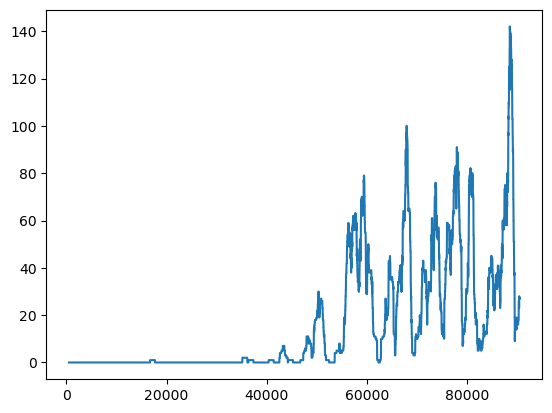

In [16]:
import pandas as pd

s = pd.Series(np.hstack(best_neuron))
# s = s.rolling(250, center=True).sum()
s = s.rolling(sample_rate*10, center=True).sum()
s.plot()
# convert back into original shape (364, 250)
mean_firing_rate = np.reshape(s.values, (364, 250))
mean_firing_rate.shape

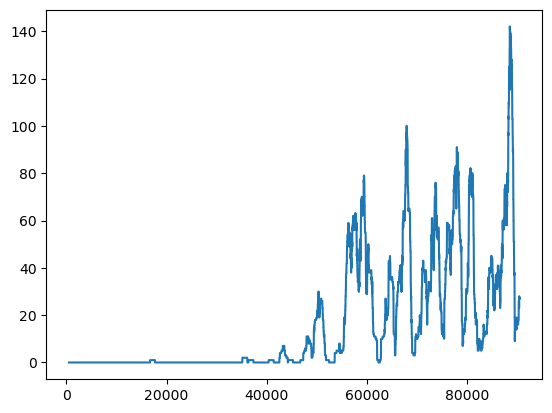

In [17]:
plt.plot(np.hstack(mean_firing_rate))

## Plot

In [18]:
np.nanmax(mean_firing_rate)

142.0

/var/folders/1y/49sjn_6j1_sgl474yd2zw6pc0000gn/T/ipykernel_14088/3516563576.py:13: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0, i].set_xlim(freqs[0], freqs[-1])


[Text(0.5, 0, '0'),
 Text(0.5, 0, '1'),
 Text(0.5, 0, '2'),
 Text(0.5, 0, '3'),
 Text(0.5, 0, '4'),
 Text(0.5, 0, '5'),
 Text(0.5, 0, '6'),
 Text(0.5, 0, '7')]

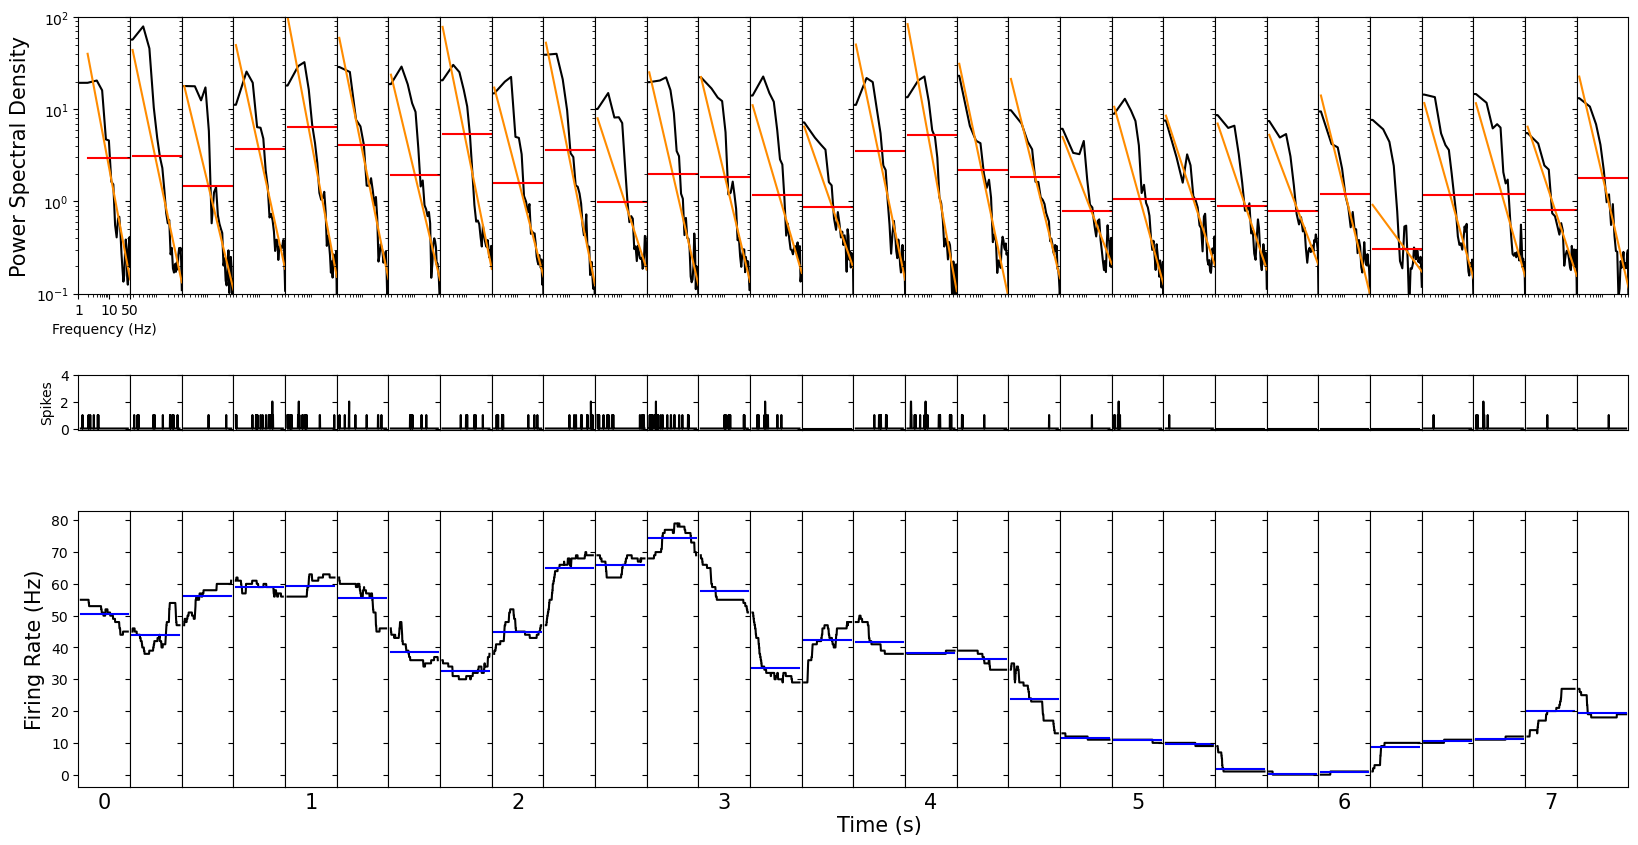

In [26]:
n_trials = 30
start = argmax_trial
fontsize = 15

fig, axes = plt.subplots(3, n_trials, figsize=(20, 10), sharey="row", sharex=False,
                         gridspec_kw={"wspace": 0, "hspace": .4, "height_ratios": [1, .2, 1]})
for i, trial in enumerate(range(start, start + n_trials)):
    axes[0, i].loglog(freqs, pwr[trial], "k")
    axes[0, i].loglog(freqs[1:], ap_powers[trial], "darkorange")
    axes[0, i].loglog(freqs[1:], mean_ap_powers[trial], "r")
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[0, i].set_xlim(freqs[0], freqs[-1])

    axes[1, i].plot(best_neuron[trial], "k")
    axes[1, i].set_yticks([])
    axes[1, i].set_xticks([])

    axes[2, i].plot(mean_firing_rate[trial], "k")
    x_bins = mean_firing_rate[trial].shape[0]
    mean_firing_rate_avg = np.ones(x_bins) * mean_firing_rate[trial].mean()
    axes[2, i].plot(mean_firing_rate_avg, "b")
    # mean_ap_powers_scaled = mean_ap_powers[trial] / mean_ap_powers.max() * np.nanmax(mean_firing_rate)
    # mean_ap_powers_scaled = np.ones(x_bins) * mean_ap_powers_scaled.mean()
    # axes[2, i].plot(mean_ap_powers_scaled, "darkorange")
    axes[2, i].set_xticks([])

axes[0, 0].set_xticks([1, 10, 50], labels=[1, 10, 50], minor=False)
axes[0, 0].set_yticks([.1, 1, 10, 100])
axes[0, 0].set_ylim([.1, 100])
axes[0, 0].set_xlabel("Frequency (Hz)")
axes[0, 0].set_ylabel("Power Spectral Density", fontsize=fontsize)

axes[1, 0].set_ylabel("Spikes")
axes[1, 0].set_yticks([0, 2, 4])

axes[2, 0].set_ylabel("Firing Rate (Hz)", fontsize=fontsize)
axes[2, n_trials // 2].set_xlabel("Time (s)", fontsize=fontsize, labelpad=20)
[axes[2, j].set_xlabel(f"{j/4:.0f}", fontsize=fontsize) for j in range(0, n_trials, 4)]